In [9]:
!pip install geopandas

In [10]:
!pip install folium

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd ## extension panda pour gérer des données géographiques
import folium ## permet de créer des cartes interactives
import requests ## pour faire des requêtes HTTP pour récupérer des données en ligne
from matplotlib import pyplot as plt ## partie de la bibliothèque Matplotlib utilisée pour faire des graphiques.
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler ## onctions de SciPy pour faire du clustering hiérarchique 

In [12]:
from shapely.geometry import Point ## Shapely est une bibliothèque Python utilisée pour manipuler des objets géométriques (points, lignes, polygones) dans un contexte géospatial.

Ouverture du fichier sur les données sociodémographiques des IRIS

In [13]:
revenus = pd.read_csv("revenus.csv", sep=";")
revenus.head()
## nous chargeons un fichier CSV nommé "revenus.csv" en utilisant la bibliothèque pandas et nous affichons les premières lignes du DataFrame résultant avec la méthode head().
## Ce tableau statistique de l'INSEE contient une colonne d'indentification géographique (IRIS) et de nombreuses colonnes de variables sur les revenus (médiane, déciles, quartiles, indices d’inégalité, parts de prestations, impôts, etc.) 

,IRIS,DISP_TP6018,DISP_Q118,DISP_MED18,DISP_Q318,DISP_EQ18,DISP_D118,DISP_D218,DISP_D318,DISP_D418,...,DISP_PCHO18,DISP_PBEN18,DISP_PPEN18,DISP_PPAT18,DISP_PPSOC18,DISP_PPFAM18,DISP_PPMINI18,DISP_PPLOGT18,DISP_PIMPOT18,DISP_NOTE18
0,010040101,20.1,14000.0,19300.0,25250.0,0.58,10340.0,13010.0,14970.0,17020.0,...,3.0,2.7,27.7,7.3,8.8,3.4,3.4,2.0,-15.1,0
1,010040102,25.7,12890.0,17530.0,23100.0,0.58,9970.0,12030.0,13710.0,15570.0,...,4.2,2.2,26.2,6.6,11.5,3.9,4.5,3.1,-13.8,0
2,010040201,19.1,14090.0,19580.0,26320.0,0.62,11000.0,13140.0,15170.0,17640.0,...,3.1,4.2,28.9,8.2,7.8,3.1,2.6,2.1,-15.8,0
3,010040202,8.9,18360.0,24530.0,31590.0,0.54,13600.0,17120.0,19550.0,21970.0,...,2.3,3.6,23.6,21.2,4.1,2.1,1.2,0.8,-20.3,0
4,010330102,18.6,14060.0,19960.0,28100.0,0.70,10230.0,13330.0,15420.0,17470.0,...,4.2,2.4,26.7,8.4,5.2,1.6,2.0,1.6,-14.7,0


In [14]:
revenus.columns = (
    revenus.columns
    .str.replace("^DISP_", "", regex=True)   # enlève le préfixe DISP_
    .str.replace("18$", "", regex=True)      # enlève le suffixe 18
    .str.lower()                             # met en minuscules
)
print(revenus.columns)
## Ici on nettoie les noms des colonnes du DataFrame en supprimant certains préfixes et suffixes spécifiques, et en convertissant tous les noms de colonnes en minuscules pour une meilleure lisibilité et cohérence. Ainsi on retir le préfixe "DISP_" et le suffixe "18" des noms de colonnes, puis on convertit tous les noms en minuscules. Enfin, on affiche les nouveaux noms de colonnes.

Index(['iris', 'tp60', 'q1', 'med', 'q3', 'eq', 'd1', 'd2', 'd3', 'd4', 'd6',
       'd7', 'd8', 'd9', 'rd', 's80s20', 'gi', 'pact', 'ptsa', 'pcho', 'pben',
       'ppen', 'ppat', 'ppsoc', 'ppfam', 'ppmini', 'pplogt', 'pimpot', 'note'],
      dtype='object')


 Ici on nettoie les noms des colonnes du DataFrame en supprimant certains préfixes et suffixes spécifiques, et en convertissant tous les noms de colonnes en minuscules pour une meilleure lisibilité et cohérence. Ainsi on retir le préfixe "DISP_" et le suffixe "18" des noms de colonnes, puis on convertit tous les noms en minuscules. Enfin, on affiche les nouveaux noms de colonnes.

CAH
Faire un indice synthétique pour pouvoir représenter facilement les caractéristiques structurelles des quartiers sur une carte

In [15]:
revenus.shape
## nombre de zones géographiques (lignes) et de variables (colonnes) dans le DataFrame revenus.

(12395, 29)

In [16]:
revenus.isna().sum()

iris         0
tp60      2881
q1           1
med          1
q3           1
eq           1
d1           1
d2           1
d3           1
d4           1
d6           1
d7           1
d8           1
d9           1
rd           1
s80s20       1
gi           1
pact         1
ptsa       440
pcho       440
pben       440
ppen         1
ppat         1
ppsoc        1
ppfam        1
ppmini       1
pplogt       1
pimpot       1
note         0
dtype: int64

In [25]:
# on retire la colonne IRIS qui correspond aux identifiants, 
# la colonne DISP_TP6018 (23% de NA) et la note de précaution
rev_cah = revenus.drop(columns=["iris", "tp60", "note", "d2", "d3", "d4", "d6", "d7", "d8"])
print(rev_cah.columns)

Index(['q1', 'med', 'q3', 'eq', 'd1', 'd9', 'rd', 's80s20', 'gi', 'pact',
       'ptsa', 'pcho', 'pben', 'ppen', 'ppat', 'ppsoc', 'ppfam', 'ppmini',
       'pplogt', 'pimpot'],
      dtype='object')


La commande revenus.isna().sum() sert à vérifier les valeurs manquantes dans ton DataFrame.revenus.isna() crée un tableau de la même taille que revenus où chaque cellule vaut :
- True si la valeur est manquante (NaN)
- False sinon
#.sum() fait la somme par colonne, donc on obtient le nombre de valeurs manquantes pour chaque colonne.

In [26]:
# on vérifie qu'on n'a que des valeurs numériques
rev_cah.dtypes

q1        float64
med       float64
q3        float64
eq        float64
d1        float64
d9        float64
rd        float64
s80s20    float64
gi        float64
pact      float64
ptsa      float64
pcho      float64
pben      float64
ppen      float64
ppat      float64
ppsoc     float64
ppfam     float64
ppmini    float64
pplogt    float64
pimpot    float64
dtype: object

In [27]:
# imputation des valeurs manquantes
for col in rev_cah.columns:
    rev_cah[col] = rev_cah[col].fillna(rev_cah[col].median())

# vérification
rev_cah.isna().sum()

## Ce code remplace toutes les valeurs manquantes par la médiane de leur colonne et vérifie ensuite qu’il n’en reste plus. Cela prépare les données pour l’analyse ou le clustering.

q1        0
med       0
q3        0
eq        0
d1        0
d9        0
rd        0
s80s20    0
gi        0
pact      0
ptsa      0
pcho      0
pben      0
ppen      0
ppat      0
ppsoc     0
ppfam     0
ppmini    0
pplogt    0
pimpot    0
dtype: int64

In [28]:
# normalisation
scaler = StandardScaler()
rev_scaled = scaler.fit_transform(rev_cah)

## La normalisation transforme les données pour que chaque colonne ait moyenne 0 et écart type 1, ce qui évite qu’une variable domine les autres et permet des analyses plus fiables.

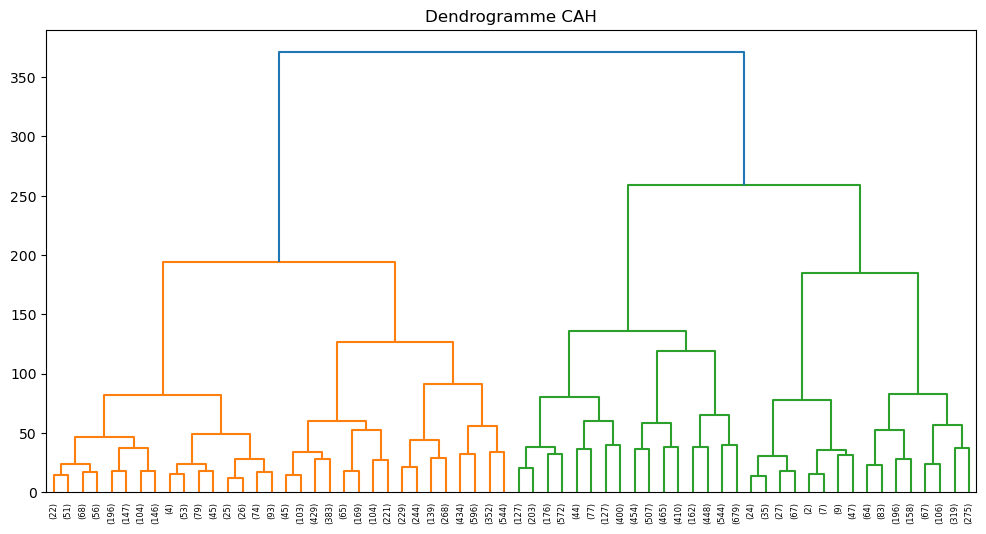

In [29]:
# CAH
Z = linkage(rev_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Dendrogramme CAH")
plt.show()

## Ce code réalise une Clustering Ascendant Hiérarchique (CAH) sur les données de revenus normalisées pour regrouper les IRIS aux caractéristiques similaires. La méthode de Ward est utilisée pour minimiser la variance à l’intérieur des clusters. Le dendrogramme affiché montre visuellement comment les IRIS sont regroupés et permet d’identifier le nombre de clusters pertinent pour analyser les profils socio-économiques des zones.*
## Expliquer comment on lit le dendrogramme

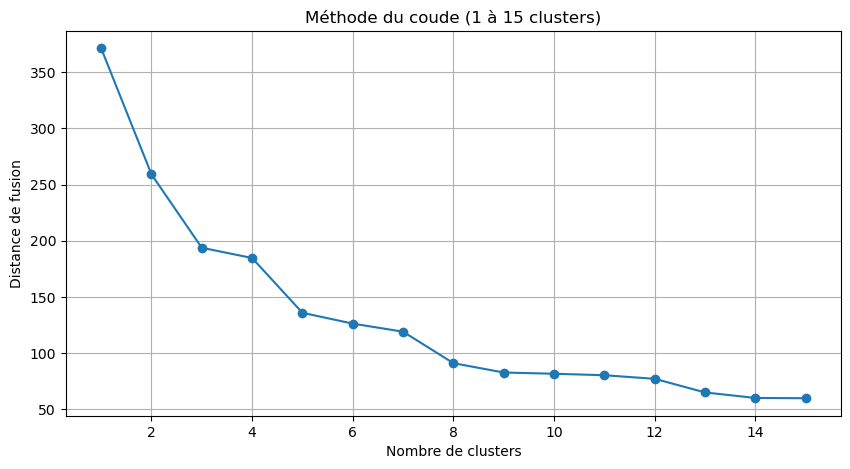

In [30]:
last = Z[:, 2]  # distances des fusions
last_rev = last[::-1]  # inversé pour l’ordre croissant

plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), last_rev[:15], marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Distance de fusion")
plt.title("Méthode du coude (1 à 15 clusters)")
plt.grid(True)
plt.show()

## On utilise la distance des fusions pour tracer une courbe et identifier le “coude”, c’est-à-dire le nombre de clusters où fusionner davantage devient peu utile. C’est une méthode visuelle et pratique pour déterminer le nombre optimal de clusters.
## L'axe x correspond au nombre de clusters et l'axe y à la distance de fusion (indique à quel point les clusters groupés sont différents). 

In [31]:
# 7. Découpage en clusters
clusters = fcluster(Z, 5, criterion='maxclust') ## on choisit 5 clusters
revenus["cluster"] = clusters

# Résumé
print(revenus["cluster"].value_counts()) ## affiche le nombre d'IRIS dans chaque cluster

vars_to_summarize = ["tp60", "med", "rd", "gi", "pact", "ppat", "ppsoc"] ## on utilise seulement certaines variables pour le résumé

summary = revenus.groupby("cluster")[vars_to_summarize].mean() ## pour chaque variable, on calcule la moyenne dans chaque cluster
total = revenus[vars_to_summarize].mean()
summary_with_total = pd.concat([summary, total.to_frame().T], axis=0)
summary_with_total.index = list(summary.index) + ["Total"]

print(summary_with_total)

cluster
3    5395
2    4325
5    1268
1    1189
4     218
Name: count, dtype: int64
            tp60           med        rd        gi       pact       ppat  \
1      46.129526  13728.637511  2.953070  0.246938  56.888394   3.586964   
2      25.916356  18086.376879  3.351561  0.267412  73.010289   5.688393   
3      13.514797  23488.464961  3.363033  0.275404  73.844123  10.537227   
4      10.473913  43935.458716  8.648165  0.502436  84.733945  34.336239   
5      11.989292  32169.834385  4.554968  0.332588  91.388644  12.943375   
Total  22.121242  21914.877360  3.534605  0.279728  73.913006   8.843190   

           ppsoc  
1      24.838772  
2      11.068231  
3       4.687968  
4       0.812844  
5       2.102839  
Total   8.514919  


Dans un premier temps, ce code attribue chaque IRIS à un cluster (le clustering se fait par rapport à toutes les variables).
Ensuite, ce code de résume les caractéristiques socio-économiques des clusters obtenus par la classification. Il compte d’abord combien d’IRIS appartiennent à chaque groupe, puis calcule la moyenne de plusieurs variables représentatives (revenu médian, inégalités, part d’actifs, etc.) pour chaque cluster. Il ajoute enfin la moyenne globale du dataset pour permettre une comparaison. Le tableau final permet donc de comprendre le profil typique de chaque cluster par rapport à l’ensemble du territoire.

In [ ]:
summary = revenus.groupby("cluster").mean(numeric_only=True) ## calculer la moyenne des colonnes numériques pour chaque cluster
total = revenus.mean(numeric_only=True) ## calculer la moyenne générale de toutes les colonnes numériques
summary_with_total = pd.concat([summary, total.to_frame().T], axis=0) ## crée un DataFrame avec les moyennes par cluster + une ligne summplémentaire avec la moyenne générale
summary_with_total.index = list(summary.index) + ["Total"]

print(summary_with_total)

            tp60            q1           med            q3        eq  \
1      46.129526  10465.189235  13728.637511  18489.798150  0.580690   
2      25.916356  13074.520231  18086.376879  24545.553757  0.630846   
3      13.514797  17320.986281  23488.464961  31347.951428  0.593521   
4      10.473913  25572.660550  43935.458716  73296.559633  1.080000   
5      11.989292  21913.257098  32169.834385  45705.402208  0.740276   
Total  22.121242  15796.406326  21914.877360  29947.380991  0.628886   

                 d1            d2            d3            d4            d6  \
1       8244.188394   9805.079899  11096.560135  12361.934399  15326.770395   
2       9697.239306  12060.157225  14059.780347  16031.364162  20329.528324   
3      12587.849462  15934.773823  18609.447534  21048.787542  26157.211717   
4      14710.596330  22177.018349  28959.678899  36127.844037  53225.596330   
5      14600.749211  19719.779180  24002.003155  28052.839117  36736.553628   
Total  11405.714055  

Après le clustering, chaque IRIS appartient à un groupe (cluster) ayant des caractéristiques similaires.

Le tableau summary te montre les moyennes par cluster pour les variables importantes (revenu médian, déciles, parts de prestations, etc.).

Ça permet de comparer les clusters entre eux : par exemple, quel cluster a les revenus les plus élevés, ou les inégalités les plus fortes.

La ligne Total représente la moyenne globale pour toutes les données, sans distinction de cluster. Elle sert de référence pour savoir si un cluster est au-dessus ou en dessous de la moyenne générale.

In [ ]:
cluster_order = revenus.groupby("cluster")["med"].median().sort_values()
print(cluster_order)
labels = ["tres_pauvre", "pauvre", "moyen", "riche", "tres_riche"]
mapping = {cluster: labels[i] for i, cluster in enumerate(cluster_order.index)}
mapping

In [ ]:
revenus["cluster_label"] = revenus["cluster"].map(mapping)
print(revenus["cluster_label"].value_counts())

Fusionner avec les contours des IRIS

In [ ]:
gdf_iris = gpd.read_file("contours-iris-pe.gpkg")

In [ ]:
gdf_iris = gdf_iris.merge(
    revenus,
    left_on="code_iris",
    right_on="iris",
    how="left"
)
print(gdf_iris.columns)

In [ ]:
print(gdf_iris.isna().sum())
gdf_iris.shape

Données démographiques sur les IRIS

In [ ]:
population = pd.read_csv("population.csv", sep=";")
population.head()

In [ ]:
population.columns = (
    population.columns
    .str.replace("^P21_", "", regex=True)   # enlève le préfixe DISP_
    .str.replace("^C21_", "", regex=True)      # enlève le suffixe 18
    .str.lower()                             # met en minuscules
)
print(population.columns)

In [ ]:
meta = pd.read_csv("meta_population.csv", sep=";")

# garder seulement les lignes correspondant à la variable IRIS
meta_iris = meta[meta["COD_VAR"] == "IRIS"]

# ne garder que le code et le nom
meta_iris = meta_iris[["COD_MOD", "LIB_MOD"]]

In [ ]:
meta_iris["COD_MOD"] = (
    meta_iris["COD_MOD"].astype(str)
                        .apply(lambda x: x[1:] if x.startswith("0") else x)
)

In [ ]:
population["iris"] = population["iris"].astype(str)
meta_iris["COD_MOD"] = meta_iris["COD_MOD"].astype(str)

In [ ]:
population = population.merge(
    meta_iris,
    left_on="iris",
    right_on="COD_MOD",
    how="left"
)

In [ ]:
population[["iris", "LIB_MOD"]].head()

Fusion des bases de données

In [ ]:
gdf_iris = gdf_iris.merge(
    population,
    left_on="code_iris",
    right_on="COD_MOD",
    how="left"
)
print(gdf_iris.columns)

In [ ]:
print(gdf_iris[["pop", "pop_fr"]].isna().sum())
gdf_iris.shape

In [ ]:
mapping_typ_iris = {
    "H": "habitat",
    "A": "activité",
    "D": "divers",
    "Z": "autre"
}

gdf_iris["type_iris_label"] = gdf_iris["type_iris"].map(mapping_typ_iris)
gdf_iris["type_iris_label"].value_counts()

Ouverture du fichier parcoursup

In [ ]:
parcoursup = "parcoursup.csv"

df = pd.read_csv(parcoursup, sep=";")
df.head()

In [ ]:
# Normaliser toutes les colonnes
df.columns = [
    col.lower()  # tout en minuscules
       .replace(' ', '_')       # espaces → _
       .replace("'", "_")       # apostrophes → _
       .replace('(', '')        # supprimer (
       .replace(')', '')        # supprimer )
       .replace(',', '')        # supprimer ,
       .replace('.', '')        # supprimer .
       .replace('…', '')
       .replace('é','e')        # accents
       .replace('è','e')
       .replace('à','a')
       .replace('ê','e')
       .replace('ç','c')
       .replace('%','percent')
       for col in df.columns
]

# Vérifier le résultat
print(df.columns)

Relier les IRIS à parcoursup

In [ ]:
df = df.rename(columns={"coordonnees_gps_de_la_formation": "coord_gps"})

df[['latitude', 'longitude']] = df['coord_gps'].str.split(',', expand=True)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

# Vérifier
df[['latitude','longitude']].head()

In [ ]:
df_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"   # CRS WGS84 pour des coordonnées GPS
)

df_points[['geometry']].head()

In [ ]:
# Transformation des IRIS en EPSG:4326
gdf_iris = gdf_iris.to_crs(epsg=4326)

# Vérifier le CRS
print(gdf_iris.crs)

In [ ]:
df_points = df_points.set_crs(4326)
gdf_iris = gdf_iris.set_crs(4326)

df_total = gpd.sjoin(
    df_points, 
    gdf_iris[['code_iris', 'nom_iris', 'geometry', 'nom_commune', 'type_iris', "med", "rd", "ppsoc", "cluster_label", "pop", "pop1117", "pop1824", "pop15p_cs3", "pop15p_cs5", "pop15p_cs6", "pop_imm"]], 
    how="left",
    predicate="within"
)

df_total.head()

In [ ]:
print(df_total.isna()[["pop", "pop_imm", "code_iris"]].sum())
print(df_total.shape)

In [ ]:
df_total["code_iris"].value_counts()

In [ ]:
df_total.columns

In [ ]:
df_total["selectivite"].value_counts()

In [ ]:
# 1. Nombre total de formations par IRIS
total_form = (
    df_total.groupby("code_iris")
      .size()
      .reset_index(name="nb_formations")
)

# 2. Nombre de formations sélectives par IRIS
selectives = (
    df_total[df_total["selectivite"] == "formation sélective"]
    .groupby("code_iris")
    .size()
    .reset_index(name="nb_form_sel")
)

# 3. Fusion des deux résultats
result = total_form.merge(selectives, on="code_iris", how="left")

# Les IRIS sans formation sélective → 0
result["nb_form_sel"] = result["nb_form_sel"].fillna(0).astype(int)

result.head(15)

In [ ]:
for col in df_total.columns:
    if "taux" in col.lower():
        print(col)

In [ ]:
df_total["taux_d’acces"].quantile([0.25, 0.333, 0.5, 0.75])

In [ ]:
(df_total["taux_d’acces"] < 50).mean()

In [ ]:
df_total["percent_d’admis_neo_bacheliers_boursiers"].quantile([0.25, 0.333, 0.5, 0.667, 0.75])

In [ ]:
(df_total["percent_d’admis_neo_bacheliers_boursiers"] < 30).mean()

In [ ]:
# créer les colonnes pour les formations très sélectives et avec un haut taux de boursiers
df_total["tres_select"] = df_total["taux_d’acces"] < 50
df_total["bcp_boursiers"] = df_total["percent_d’admis_neo_bacheliers_boursiers"] > 30

# compter par IRIS
result2 = df_total.groupby("code_iris")[["tres_select", "bcp_boursiers"]].sum().reset_index()

# fusionner aux autres colonnes créées 
result3 = result.merge(result2, on="code_iris", how="left")

# afficher
result3

Ajouter ces colonnes à la base sur les iris

In [ ]:
gdf_iris = gdf_iris.merge(result3, on="code_iris", how="left")
gdf_iris[["nb_formations", "nb_form_sel", "tres_select", "bcp_boursiers"]].head(15)

In [ ]:
# Remplacer les NaN par 0 pour les colonnes issues des données parcoursup
gdf_iris["nb_formations"] = gdf_iris["nb_formations"].fillna(0)

# Vérification
gdf_iris["nb_formations"].head(30)

In [ ]:
gdf_iris["nb_formations_cat"] = "0"

# sélectionner les valeurs > 0
mask = gdf_iris["nb_formations"] > 0

# créer les quantiles sur le reste
gdf_iris.loc[mask, "nb_formations_cat"] = pd.qcut(gdf_iris.loc[mask, "nb_formations"], 
                                            q=2, 
                                            labels=["Q1","Q2"])

gdf_iris.groupby("nb_formations_cat")["pop"].mean()

In [ ]:
# Centrer la carte sur Besançon
besancon_lon, besancon_lat = 6.025, 47.237
#m = folium.Map(location=[besancon_lat, besancon_lon], zoom_start=13)

# Ajouter les polygones IRIS
folium.GeoJson(
    gdf_iris,
    name="IRIS",
    style_function=lambda x: {"fillColor": "blue", "color": "black", "weight": 1, "fillOpacity": 0.2}
).add_to(m)

# Filtrer les points valides
df_points_valid = df_points.dropna(subset=['latitude', 'longitude'])

# Boucle sur les points valides
for idx, row in df_points_valid.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Ajouter contrôle des couches
#folium.LayerControl().add_to(m)

# Afficher la carte
#m

In [ ]:
# 1) Ajouter un code département à partir du code IRIS
gdf_iris["code_iris"] = gdf_iris["code_iris"].astype(str)
gdf_iris["code_dept"] = gdf_iris["code_iris"].str[:2]

# 2) Garder uniquement l'Île-de-France
idf_deps = ["75", "77", "78", "91", "92", "93", "94", "95"]
gdf_idf = gdf_iris[gdf_iris["code_dept"].isin(idf_deps)].copy()

print("Nombre d'IRIS en IDF :", gdf_idf.shape[0])

# 3) Palette de couleurs pour les types de quartiers (clusters)
cluster_colors = {
    "tres_pauvre": "#b30000",  # rouge foncé
    "pauvre":      "#fc8d59",  # orange
    "moyen":       "#fee08b",  # jaune
    "riche":       "#91bfdb",  # bleu clair
    "tres_riche":  "#4575b4",  # bleu foncé
}

def style_cluster(feature):
    label = feature["properties"].get("cluster_label")
    color = cluster_colors.get(label, "#cccccc")  # gris si NaN
    return {
        "fillColor": color,
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.6,
    }

# 4) Filtrer les formations qui sont dans un IRIS IDF
idf_iris_codes = set(gdf_idf["code_iris"].astype(str).unique())

df_points_idf = df_total[
    df_total["code_iris"].astype(str).isin(idf_iris_codes)
].dropna(subset=["latitude", "longitude"])

print("Nombre de formations en IDF :", df_points_idf.shape[0])

# 5) Créer une carte centrée sur Paris
m = folium.Map(
    location=[48.8566, 2.3522],
    zoom_start=10,
    max_zoom=10,
    min_zoom=10,
    dragging=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
    zoomControl=False
)


# 6) Ajouter les polygones IRIS colorés selon le type de quartier
folium.GeoJson(
    gdf_idf,
    name="Quartiers (IRIS)",
    style_function=style_cluster,
    tooltip=folium.GeoJsonTooltip(
        fields=["nom_iris", "nom_commune", "cluster_label"],
        aliases=["IRIS", "Commune", "Type de quartier"],
        localize=True
    ),
).add_to(m)

# 7) Ajouter les formations en points rouges
for _, row in df_points_idf.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=1,
        color="red",
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

folium.LayerControl().add_to(m)
#m
print("ok")

In [ ]:
## hello 